# 代码逻辑

代码共有5个板块：导入模块、全局参数、回归模型、创建类、main

导入模块：包含所有包的调用。

全局参数：包含所有全局参数（路径、画图参数）等的调整。

回归模型：机器学习建模的函数，主要在class中被调用。

创建类：将代码和功能打包，主要包括：
- 类的赋值self.\__init\__()：如何接受到因子和收益率数据、按怎样的频率滚动和扩展窗口、训练集测试集的起止时间设置；
- 赋值后的样本外收益率预测self.predict_ret()：根据训练集，通过不同的机器学习方法训练模型，并计算出样本外预测值；
- 计算样本外的R2 self.cal_oos()：根据样本外预测值和真实值的差异来计算R2，公式为：
$$R^2_{oos} = 1 - \frac{\sum(r_{i,t+1} - \hat r_{i,t+1})^2}{\sum r_{i,t+1}^2} $$

main：代码主函数，将class实例化，并计算不同模型的样本外R2。

# 导入模块 

In [3]:
import os # 管理路径
import math
from tqdm import tqdm,trange # 显示进度条
from datetime import timedelta
import warnings; 
warnings.filterwarnings("ignore")

import pandas as pd 
from pandas.tseries.offsets import Day, MonthEnd, MonthBegin # 时间处理
import numpy as np

# 机器学习模型
from sklearn import linear_model
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#import baostock as bs
#from WindPy import *
#lg = bs.login()
#w.start()

# 全局参数

In [4]:
# 设置路径
#############################################请修改#########################################################
datapath = r'E:\终生学习\职业素养\学术论文\【202010】emperical asset pricing via machine learning\data' # 数据存储路径
###########################################################################################################
pd.options.display.max_columns = 10 # notebook中最大显示列数
pd.options.display.max_rows = 10 # notebook中最大显示行数

# 回归模型

In [5]:
# 超参调整，训练模型，这里的函数是不同的模型进行调参。

# elastic net
def ENReg(X_train, y_train, X_valid, y_valid):
    best_en = ElasticNet(alpha=1.0, l1_ratio=1).fit(X_train, y_train) # 先用1.0和1为参数训练模型
    best_en_score = best_en.score(X_valid, y_valid) # 得到该参数下的得分
    for i in range(1, 20): # 调整超参
        alpha_counter = math.pow(0.1, i)
        for r in range(21): # 调整超参
            l1_ratio_counter = r * 0.05
            en_temp = ElasticNet(alpha=alpha_counter, l1_ratio=l1_ratio_counter).fit(X_train, y_train) # 用此时的超参训练模型
            if en_temp.score(X_valid, y_valid) > best_en_score: # 如果新模型的得分高于之前的得分，则取代之前的模型
                best_alpha = alpha_counter # 最高得分下的超参alpha
                best_l1_ratio = l1_ratio_counter # 最高得分下的超参l1_ratio
                best_en = ElasticNet(alpha=alpha_counter, l1_ratio=l1_ratio_counter).fit(X_train, y_train) # 用最好的模型训练模型
                best_en_score = best_en.score(X_valid, y_valid) # 得到最高的得分
    return best_en # 返回训练的最好的模型

#PLS
def PLSReg(X_train, y_train, X_valid, y_valid):
    pls_best = PLSRegression(n_components=1).fit(X_train, y_train) # 先用n_components = 1来训练模型
    for i in range(1, min(X_train.shape[1],100)): # 调整参数
        pls_temp = PLSRegression(n_components=i).fit(X_train, y_train) 
        if pls_temp.score(X_valid, y_valid) > pls_best.score(X_valid, y_valid): # 训练出最好的参数
            best_pls_conponents = i
            pls_best = PLSRegression(n_components=best_pls_conponents).fit(X_train, y_train)
    return pls_best

#GL待优化
def group_lasso(X, y, alpha, groups, max_iter=1000, rtol=1e-6,
             verbose=False):
    """
    Linear least-squares with l2/l1 regularization solver.
    Solves problem of the form:
               .5 * |Xb - y| + n_samples * alpha * Sum(w_j * |b_j|)
    where |.| is the l2-norm and b_j is the coefficients of b in the
    j-th group. This is commonly known as the `group lasso`.
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Design Matrix.
    y : array of shape (n_samples,)
    alpha : float or array
        Amount of penalization to use.
    groups : array of shape (n_features,)
        Group label. For each column, it indicates
        its group apertenance.
    rtol : float
        Relative tolerance. ensures ||(x - x_) / x_|| < rtol,
        where x_ is the approximate solution and x is the
        true solution.
    Returns
    -------
    x : array
        vector of coefficients
    References
    ----------
    "Efficient Block-coordinate Descent Algorithms for the Group Lasso",
    Qin, Scheninberg, Goldfarb
    """

    # .. local variables ..
    # 检查赋值的格式是否正确
    X, y, groups, alpha = map(np.asanyarray, (X, y, groups, alpha))
    if len(groups) != X.shape[1]:
        raise ValueError("Incorrect shape for groups")
    w_new = np.zeros(X.shape[1], dtype=X.dtype)
    alpha = alpha * X.shape[0]

    # .. use integer indices for groups ..
    # 调整超参
    group_labels = [np.where(groups == i)[0] for i in np.unique(groups)]
    H_groups = [np.dot(X[:, g].T, X[:, g]) for g in group_labels]
    eig = list(map(linalg.eigh, H_groups))
    Xy = np.dot(X.T, y)
    initial_guess = np.zeros(len(group_labels))

    def f(x, qp2, eigvals, alpha):
        return 1 - np.sum( qp2 / ((x * eigvals + alpha) ** 2))
    def df(x, qp2, eigvals, penalty):
        # .. first derivative ..
        return np.sum((2 * qp2 * eigvals) / ((penalty + x * eigvals) ** 3))

    if X.shape[0] > X.shape[1]:
        H = np.dot(X.T, X)
    else:
        H = None

    for n_iter in range(max_iter):
        w_old = w_new.copy()
        for i, g in enumerate(group_labels):
            # .. shrinkage operator ..
            eigvals, eigvects = eig[i]
            w_i = w_new.copy()
            w_i[g] = 0.
            if H is not None:
                X_residual = np.dot(H[g], w_i) - Xy[g]
            else:
                X_residual = np.dot(X.T, np.dot(X[:, g], w_i)) - Xy[g]
            qp = np.dot(eigvects.T, X_residual)
            if len(g) < 2:
                # for single groups we know a closed form solution
                w_new[g] = - np.sign(X_residual) * max(abs(X_residual) - alpha, 0)
            else:
                if alpha < linalg.norm(X_residual, 2):
                    initial_guess[i] = optimize.newton(f, initial_guess[i], df, tol=.5,
                                args=(qp ** 2, eigvals, alpha))
                    w_new[g] = - initial_guess[i] * np.dot(eigvects /  (eigvals * initial_guess[i] + alpha), qp)
                else:
                    w_new[g] = 0.


        # .. dual gap ..
        max_inc = linalg.norm(w_old - w_new, np.inf)
        if True: #max_inc < rtol * np.amax(w_new):
            residual = np.dot(X, w_new) - y
            group_norm = alpha * np.sum([linalg.norm(w_new[g], 2)
                         for g in group_labels])
            if H is not None:
                norm_Anu = [linalg.norm(np.dot(H[g], w_new) - Xy[g]) \
                           for g in group_labels]
            else:
                norm_Anu = [linalg.norm(np.dot(H[g], residual)) \
                           for g in group_labels]
            if np.any(norm_Anu > alpha):
                nnu = residual * np.min(alpha / norm_Anu)
            else:
                nnu = residual
            primal_obj =  .5 * np.dot(residual, residual) + group_norm
            dual_obj   = -.5 * np.dot(nnu, nnu) - np.dot(nnu, y)
            dual_gap = primal_obj - dual_obj
            if verbose:
                print('Relative error: %s' % (dual_gap / dual_obj))
            if np.abs(dual_gap / dual_obj) < rtol:
                break

    return w_new

# Random forest
def RFReg(X_train, y_train, X_valid, y_valid):
    rf_best = RandomForestRegressor().fit(X_train, y_train)
    for L in range(1,10): # 调整超参L
        for B in range(1,10): # 调整超参B
            rf_temp = RandomForestRegressor(n_estimators=10, max_depth=None).fit(X_train, y_train)
            if rf_temp.score(X_valid, y_valid)> rf_best.score(X_valid, y_valid): # 保留使得模型得分最好的B\L
                L_best = L
                B_best = B
                rf_best = RandomForestRegressor(n_estimators=B_best, max_depth=L_best).fit(X_train, y_train) # 用最好的参数训练模型
    return rf_best

# gradient boosting regression trees
def GBRTReg(X_train, y_train, X_valid, y_valid):
    gbrt_best = GradientBoostingRegressor(loss='huber').fit(X_train, y_train) 
    for L in range(1, 5): # 调整超参L
        for v in range(1,5): # 调整超参learning_rate
            learning_rate = v *0.1
            for B in range(20,100,10): # 调整超参B
                gbrt_temp = GradientBoostingRegressor(loss='huber',learning_rate=learning_rate, n_estimators=B, max_depth=L).fit(X_train, y_train)
                if gbrt_temp.score(X_valid, y_valid)> gbrt_best.score(X_valid, y_valid):
                    L_best = L
                    learning_rate_best = learning_rate
                    B_best = B
                    gbrt_best = GradientBoostingRegressor(loss='huber',learning_rate=learning_rate_best, n_estimators=B_best, max_depth=L_best).fit(X_train, y_train)
    return gbrt_best # 返回得分最高的模型

# 创建类

In [6]:
class Factor_models(object):
    '''
    params:
    -------
        chardf:个股特征值的面板数据，index为日期格式，columns为features。
        retdf:个股收益率的面板数据，index为日期格式。
        first_train_end_date:初次训练时，训练集的截止日期。（开始日期默认为chardf和retdf的第一期）。格式为'%Y%m%d'。
        last_train_end_date:最后一次训练时，训练集的截止日期。格式为'%Y%m%d'。
        freq:按什么频率expanding训练集，默认为'm'，每个月滚动一次。
    
    methods:
    --------
    
    '''
    def __init__(self,chardf,retdf,first_train_end_date,last_train_end_date,freq='m'):
        '''
        参数初始化
        '''
        self._chardf = chardf # 个股特征值的面板数据
        self._retdf = retdf # 个股收益率的面板数据
        self.first_train_end_date = first_train_end_date # 初次训练时，训练集的截止日期。之后训练集每月expanding。
        self.last_train_end_date = last_train_end_date # 最后一次训练时，训练集的截止日期。即样本的截止日期。
        self.freq = freq # 训练集expanding的频率，是按月还是按年还是其他？
        
    def predict_ret(self):
        # 创建一个train_end_list，训练集每月expanding。
        train_end_list = pd.date_range(self.first_train_end_date,self.last_train_end_date,freq=self.freq) # freq=m，按月度滚动
        preddf = pd.DataFrame() # 存储不同模型预测出来的y值，即存储样本外预测收益率的值
        for end_date in tqdm(train_end_list): # 通过逐月改变训练集end_date的方法，切割样本
            # end_date = train_end_list[0]  
            valid_date = end_date + MonthEnd() # 验证集为训练集后的第一个月，每次训练完之后预测一个月
            end_date = end_date.strftime('%Y%m%d') # 转化成字符型
            valid_date = valid_date.strftime('%Y%m%d') # 转化为字符型

            # 划分集合
            # 训练集
            train_x = chardf.loc[:end_date] # 训练集为期初至end_date，end_date是按月滚动的值
            train_y = retdf.loc[:end_date] # 训练集为期初至end_date，end_date是按月滚动的值

            # 测试集
            valid_x = chardf.loc[valid_date:valid_date] # 测试集为训练集的次月，只预测下个月的月度收益率
            valid_y = retdf.loc[valid_date:valid_date] # 测试集为训练集的次月，只预测下个月的月度收益率

            # 数据标准化? 这里有问题。。。
            # train_x = (train_x - train_x.mean()) / np.std(train_x)
            # train_y = (train_y - train_y.mean()) / np.std(train_y)

            # 建模预测收益率
            ## 先创建一个临时的temp_preddf,用来存储当前月份的验证集下的real y和不同模型的预测y
            temp_preddf = pd.DataFrame() # 创建当前训练集下训练出的predict y和real y
            temp_preddf['real_y'] = valid_y.iloc[:,0]  # real_y就是验证集valid_y的第一列。因为valid_y是真实收益率数据在vailid_date上的切割

            ## OLS，已优化
            reg = linear_model.LinearRegression() # 根据OLS模型预测收益率
            reg.fit(train_x,train_y)
            predict_y = reg.predict(valid_x)
            temp_preddf['OLS_y'] = predict_y # 新建一列OLS_y存储OLS预测出的收益率

            ## PLS，已优化
            pls = PLSReg(train_x, train_y, valid_x, valid_y) # 根据PLS模型预测收益率
            predict_y = pls.predict(valid_x)
            temp_preddf['PLS_y'] = predict_y # 新建一列PLS_y存储PLS预测出的收益率

            ## PCR，待优化
            pca = PCA(n_components='mle',svd_solver='full') # 根据PCR模型预测收益率
            pca.fit(train_x)
            temp = pca.transform(train_x)
            lr = linear_model.LinearRegression()
            lr.fit(temp,train_y)   # 模型训练
            predict_y = lr.predict(pca.transform(valid_x))
            temp_preddf['PCR_y'] = predict_y # 新建一列PCR_y存储PCR预测出的收益率

            ## Elastic Net，已优化
            enet = ENReg(train_x, train_y, valid_x, valid_y) # 根据elastic net模型预测收益率
            predict_y = enet.predict(valid_x)
            temp_preddf['ENet_y'] = predict_y # 新建一列enet_y存储PCR预测出的收益率

            ## lasso，已优化
            lasso = linear_model.Lasso() # 根据lasso模型预测收益率
            param = [{'alpha':np.linspace(0,1,100)}]
            grid = GridSearchCV(lasso, param_grid=param) # 网格法调整超参
            grid.fit(train_x,train_y)
            predict_y = grid.predict(valid_x)
            temp_preddf['lasso_y'] = predict_y # 新建一列lasso_y存储lasso预测出的收益率

            ## GLM with group lasso，还没搞懂

            ## RF, 已优化
            clf = RFReg(train_x, train_y, valid_x, valid_y)  # 根据random forest模型预测收益率
            predict_y = clf.predict(valid_x)
            temp_preddf['rf_y'] = predict_y

            ## GBRT，已优化
            gbrt = GBRTReg(train_x, train_y, valid_x, valid_y)  # 根据GBRT模型预测收益率
            predict_y = gbrt.predict(valid_x)
            temp_preddf['gbrt_y'] = predict_y

            ## NN1,未调参
            ### 一层的神经网络
            regr = MLPRegressor(hidden_layer_sizes=3, random_state=1, max_iter=500)  # 超参未调
            regr.fit(train_x, train_y)
            predict_y = regr.predict(valid_x)
            temp_preddf['NN1_y'] = predict_y

            ## NN2,未调参
            ### 两层的神经网络
            regr = MLPRegressor(hidden_layer_sizes=4, random_state=1, max_iter=500) # 超参未调
            regr.fit(train_x, train_y)
            predict_y = regr.predict(valid_x)
            temp_preddf['NN2_y'] = predict_y

            ## NN3,未调参
            ### 三层的神经网络
            regr = MLPRegressor(hidden_layer_sizes=5, random_state=1, max_iter=500) # 超参未调
            regr.fit(train_x, train_y)
            predict_y = regr.predict(valid_x)
            temp_preddf['NN3_y'] = predict_y

            ## NN4,未调参
            ### 四层的神经网络
            regr = MLPRegressor(hidden_layer_sizes=6, random_state=1, max_iter=500) # 超参未调
            regr.fit(train_x, train_y)
            predict_y = regr.predict(valid_x)
            temp_preddf['NN4_y'] = predict_y

            ## NN5,未调参
            ### 五层的神经网络
            regr = MLPRegressor(hidden_layer_sizes=7, random_state=1, max_iter=500) # 超参未调
            regr.fit(train_x, train_y)
            predict_y = regr.predict(valid_x)
            temp_preddf['NN5_y'] = predict_y

            ## 将temp_preddf并入preddf
            preddf = preddf.append(temp_preddf) # 将当前valid_date下得到的predict_y和real_y一起并入preddf中
            self._preddf = preddf
        return preddf # 最后我们只返回preddf，也就是所有期的predict y和real y
    
    def cal_oos(self):
        # 计算out-of-sample R2 根据代码开头的公式
        try:
            preddf = self._preddf # 如果self已经有self._preddf，即self.predict_ret()已经运行过了，已经预测过收益率了，则无需再次运行。
        except:
            preddf = self.predict_ret() # 如果之前没有运行过self.predict_ret()，则需要运行。
        denominator = (preddf['real_y'] ** 2).sum() # 分母是真实收益率的平方和
        numerator = preddf.apply(lambda x: preddf['real_y'] - x).iloc[:,1:] # 分子是real_y - predict_y的平方和
        numerator = (numerator ** 2).sum()
        
        roos = 1 - numerator / denominator # 再用 1 减去分子/分母
        roos.index = roos.index.str.rstrip('_y') # 之前的index都是模型_y，比如"OLS_y"，不美观，删除_y。
        fig,ax = plt.subplots(figsize = (16,12)) # 画图，将不同模型的Roos画出来。
        plt.title('Out-of-sample predicting R2', fontsize = 20)
        ax.bar(x = roos.index, height = roos)
        plt.show()
        return roos # 返回样本外Roos，这个Roos是不同模型对应的样本外R2

# main

主函数，主函数里首先设置好工作路径，并读取因子数据。

In [8]:
# 导入chardf, retdf数据，并做好缺失值处理
os.chdir(datapath) # 将路径设置为《全局参数》中的datapath
totaldf = pd.read_csv('中证500_20100101_20200930月度因子数据.csv',index_col=0) # 读取因子数据
totaldf = totaldf.set_index('date') # 将date设置为index
totaldf.index = pd.to_datetime(totaldf.index)
# 缺失值处理
## 首先看一下缺失值是哪些
print('Missing data: {} items\n'.format(len(totaldf[totaldf.isna().any(1)])), totaldf[totaldf.isna().any(1)]) # 看一下缺失值是哪些行
## 缺失值不多，简单处理可以直接剔除
totaldf = totaldf.dropna(how='any') # 直接删除
chardf = totaldf.iloc[:,2:] # features
retdf = totaldf[['mret']] # monthly ret

Missing data: 8 items
                  code      mret  size  bm
date                                     
2010-01-31  000022.SZ       NaN   NaN NaN
2010-02-28  000022.SZ       NaN   NaN NaN
2010-03-31  000022.SZ       NaN   NaN NaN
2010-04-30  000022.SZ       NaN   NaN NaN
2010-05-31  000022.SZ       NaN   NaN NaN
2010-06-30  000022.SZ       NaN   NaN NaN
2012-02-29  600102.SH -0.140056   NaN NaN
2018-12-31  600270.SH -5.747643   NaN NaN


In [9]:
chardf # 因子df

,size,bm
date,,
2010-01-31,1.225713e+10,0.420704
2010-01-31,5.878727e+09,0.442315
2010-01-31,8.116641e+09,0.160954
2010-01-31,2.504960e+09,0.365256
2010-01-31,3.374784e+09,0.401930
...,...,...
2020-09-30,3.646009e+10,0.056334
2020-09-30,4.573680e+10,0.056051
2020-09-30,3.778278e+10,0.038479


In [10]:
retdf # 月度收益率df

,mret
date,
2010-01-31,24.410774
2010-01-31,14.727273
2010-01-31,13.866540
2010-01-31,-7.829978
2010-01-31,-11.498810
...,...
2020-09-30,-6.347826
2020-09-30,-13.054112
2020-09-30,-4.731282


In [12]:
# 赋值 其中train_set是expanding window,初始为20100131至20131231,之后每月扩展,valid_set是1个月的rolling window即train_set的下一个月
# 这里的last_train_end_date最高可以放到倒数第二期，在我的数据里即为20200831,用前10年数据训练模型来预测最后一期的r
# 但如果将last_train_end_date设置为20200831,需要运行4个小时左右。
basic_2_factors = Factor_models(chardf, retdf, first_train_end_date='20131231', last_train_end_date='20140331', freq='m') # 将class实例化。

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:23<00:00, 155.79s/it]


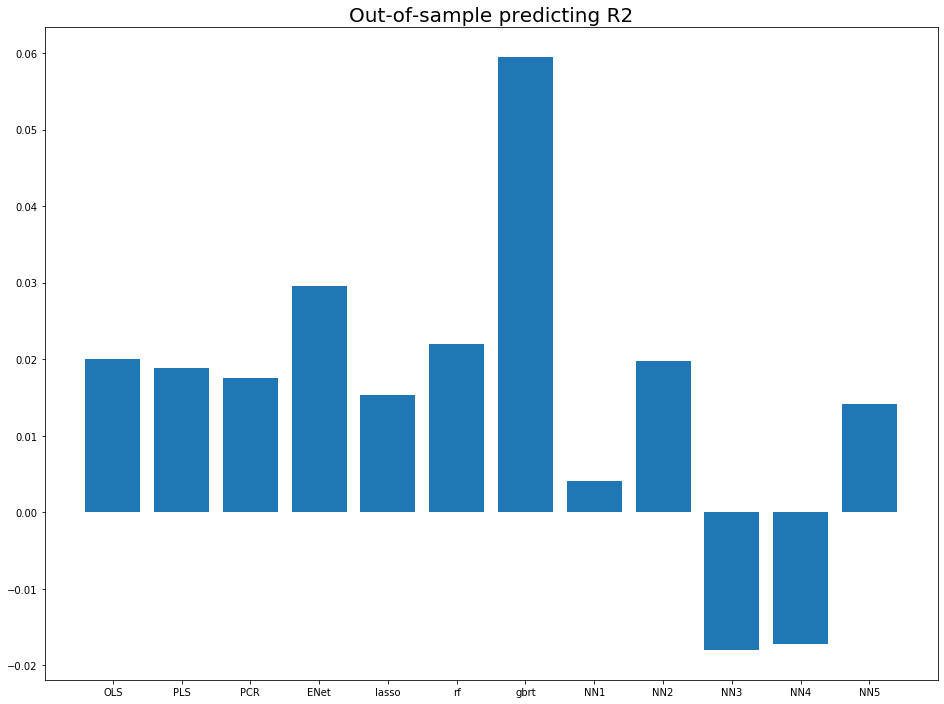

In [13]:
# 计算样本外R2，运行耗时较长
roos = basic_2_factors.cal_oos() # 计算不同模型样本外R2。self.cal_oos()中已经包含了self.predict_ret()的操作，先通过不同的模型预测收益率，再比较样本外真实收益率和预测收益率的差异

In [14]:
# 查看不同模型在不同月份的样本外预测ret
basic_2_factors._preddf

,real_y,OLS_y,PLS_y,PCR_y,ENet_y,...,NN1_y,NN2_y,NN3_y,NN4_y,NN5_y
date,,,,,,,,,,,
2014-01-31,-3.309353,-1.102139,-1.915149,1.072854,-1.102139,...,1.524180,0.905840,1.215264,1.184254,0.849959
2014-01-31,-1.718213,-2.698197,-3.445749,-0.438182,-2.698197,...,0.997728,0.220658,1.104066,1.184254,0.617411
2014-01-31,-1.968504,-2.010228,-3.116305,1.020463,-2.010228,...,1.505927,0.722103,1.211408,1.184254,0.842165
2014-01-31,-3.663793,0.700272,-0.053970,2.454937,0.700272,...,2.005704,1.596813,1.316972,1.184254,1.062553
2014-01-31,-14.989733,0.977981,-1.074857,5.863970,0.977981,...,3.193427,2.519208,1.567846,1.184254,1.588249
...,...,...,...,...,...,...,...,...,...,...,...
2014-04-30,-1.033231,1.605075,1.608639,1.373109,1.570506,...,1.649842,1.180452,1.562396,1.184879,-0.959424
2014-04-30,-13.211845,1.141416,1.262925,0.695535,1.074969,...,1.408109,0.952408,1.475372,1.184879,-0.857063
2014-04-30,11.386139,4.450256,4.389508,3.940560,4.374298,...,2.565811,2.256790,1.892144,1.184879,-1.347646


In [15]:
# 样本外预测r2
roos

OLS      0.020053
PLS      0.018920
PCR      0.017590
ENet     0.029590
lasso    0.015401
           ...   
NN1      0.004113
NN2      0.019791
NN3     -0.018000
NN4     -0.017171
NN5      0.014176
Length: 12, dtype: float64